In [27]:
BMI_THRESHOLD = 30
BINS = 20


## Setup

In [3]:
import pandas
import numpy

import matplotlib.pyplot as plt

from scipy import stats
from typing import Iterable


In [ ]:
# H0: mean(control's SkinThickness) = mean(treatment's SkinThickness)
# H1: mean(control's SkinThickness) < mean(treatment's SkinThickness)

In [5]:
df = pandas.read_csv(
    "https://course-resources.minerva.edu/uploaded_files/mu/00294342-2873/diabetes.csv"
)
df = df[(df["BMI"] != 0) & (df["SkinThickness"] != 0)]


## #descriptivestats

In [15]:
df.describe()[["BMI", "SkinThickness"]]

,BMI,SkinThickness
count,539.000000,539.000000
mean,32.895733,29.176252
std,6.871851,10.489706
min,18.200000,7.000000
25%,27.850000,22.000000
50%,32.800000,29.000000
75%,36.900000,36.000000
max,67.100000,99.000000


In [6]:
control = df[df["BMI"] < BMI_THRESHOLD]
treatment = df[df["BMI"] >= BMI_THRESHOLD]


In [17]:
control.describe()[["BMI", "SkinThickness"]]

,BMI,SkinThickness
count,189.000000,189.000000
mean,25.887302,21.370370
std,2.834879,7.214817
min,18.200000,7.000000
25%,24.200000,17.000000
50%,26.200000,20.000000
75%,28.200000,27.000000
max,29.900000,39.000000


In [18]:
treatment.describe()[["BMI", "SkinThickness"]]

,BMI,SkinThickness
count,350.000000,350.000000
mean,36.680286,33.391429
std,5.244299,9.527125
min,30.000000,11.000000
25%,33.100000,27.250000
50%,35.500000,32.000000
75%,39.100000,40.000000
max,67.100000,99.000000


## #distributions

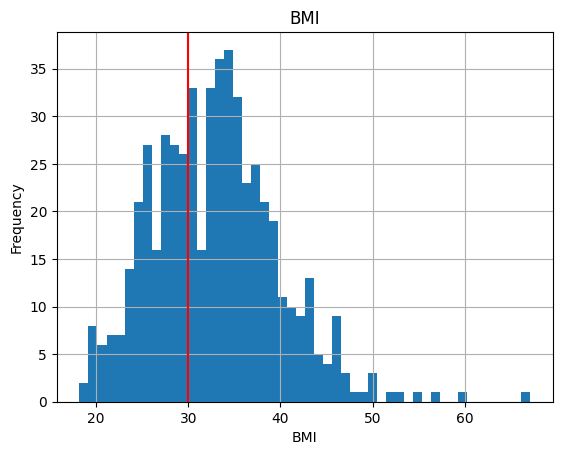

In [14]:
df.hist(column="BMI", bins=50)
plt.axvline(BMI_THRESHOLD, color="r")
plt.title("BMI")
plt.xlabel("BMI")
plt.ylabel("Frequency")
plt.show()


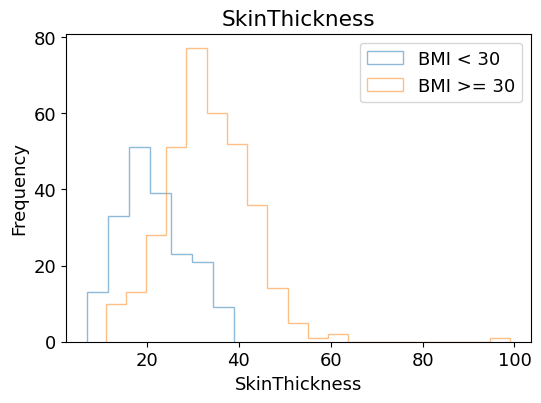

In [30]:
control_range = control["SkinThickness"].max() - control["SkinThickness"].min()
treatment_range = treatment["SkinThickness"].max() - treatment["SkinThickness"].min()
max_range = max(control_range, treatment_range)
control_bins = round(control_range / max_range * BINS)
treatment_bins = round(treatment_range / max_range * BINS)

plt.hist(
    control["SkinThickness"],
    label=f"BMI < {BMI_THRESHOLD}",
    alpha=0.5,
    bins=control_bins,
    histtype="step",
)
plt.hist(
    treatment["SkinThickness"],
    label=f"BMI >= {BMI_THRESHOLD}",
    alpha=0.5,
    bins=treatment_bins,
    histtype="step",
)
plt.title("SkinThickness")
plt.xlabel("SkinThickness")
plt.ylabel("Frequency")
plt.legend()
plt.show()


## #significance

In [41]:
def difference_of_means_test(
    control: Iterable[float], treatment: Iterable[float], tails: int = 1
):
    n_1, n_2 = len(control), len(treatment)
    x_1, x_2 = numpy.mean(control), numpy.mean(treatment)

    # sample SD formula (aka Bessel’s correction): use n-1 in denominator
    s_1, s_2 = numpy.std(control, ddof=1), numpy.std(treatment, ddof=1)

    # conservative estimate from OpenIntro
    DOF = min(n_1, n_2) - 1

    SE = numpy.sqrt(s_1**2 / n_1 + s_2**2 / n_2)
    t_score = numpy.abs((x_2 - x_1)) / SE
    p_value = tails * stats.t.cdf(-t_score, DOF)

    # OpenIntro section 5.3.6
    pooled_SD = numpy.sqrt(
        (s_1**2 * (n_1 - 1) + s_2**2 * (n_2 - 1)) / (n_1 + n_2 - 2)
    )
    cohen_d = (x_2 - x_1) / pooled_SD

    return p_value, cohen_d


In [42]:
p_value, cohen_d = difference_of_means_test(
    control["SkinThickness"], treatment["SkinThickness"]
)
print(f"p-value: {p_value}, Cohen's d: {cohen_d}")


p-value: 4.528017967991327e-19, Cohen's d: 1.2500796162147971


## Sampling

In [19]:
from scipy import stats

plt.rcParams.update({'font.size': 13})
plt.rcParams["figure.figsize"] = [6,4]

def plot_pop(alpha,beta,size):
    population = stats.beta.rvs(alpha,beta,size=size)*200
    # Note: running this cell again will produce a slightly different distribution.
    # ...Why? Consider investigating the rvs function further.
    plt.hist(population,color='orange')
    plt.title("Population Distribution")
    plt.ylabel('Frequency')
    plt.xlabel('X')
    print("Here's what your population distribution looks like:")
    plt.show()
    print("The population mean is:", round(numpy.mean(population),1))
    return population

def sample_procedure(dist,n,repeats):
    # this function implements the full sampling process
    # dist is the population distribution
    # n is the sample size
    
    # lots of samples:
    sample_means = []
    for i in range(repeats):
        sample = numpy.random.choice(dist, (n, ))
        this_mean = numpy.mean(sample)
        sample_means.append(this_mean)
        # if i<3:
            # print("\nSample #",i+1,":",[round(elem, 1) for elem in sample])
            # print("This sample has a mean of:",numpy.mean(sample))
    # print("\n...\n...\n\nSampling many ("+str(repeats)+") more times to approximate infinitely many samples...\n")
    
    return sample_means

def plot_sampling_dist(sample_means,dist,n,repeats):
    # this function plots the sampling distribution
    print("\nBased on",repeats,"samples of size",n,", here's what the sampling distribution of the sample mean looks like.\n")
    fig, ax = plt.subplots()
    ax.hist(sample_means,color='blue',density=1)
    x = numpy.linspace(min(sample_means)-1, max(sample_means)+1, 100)
    plt.xlim(min(x),max(x))
    # ax.plot(x, stats.norm.pdf(x, numpy.mean(sample_means), numpy.std(sample_means)),linewidth=2,color='red')
    plt.title('Sampling Distribution of the Sample Mean\nn='+str(n))
    plt.ylabel('Frequency')
    plt.xlabel('Sample Mean')    
    plt.show()
    res = stats.probplot(sample_means, plot=plt)
    plt.title('Normal Probability (QQ) Plot')
    plt.show()
    
    print("\nThe mean of the sample means is:", round(numpy.mean(sample_means),1))
    print("The standard deviation of the sample means is:", round(numpy.std(sample_means),1))

Here's what your population distribution looks like:


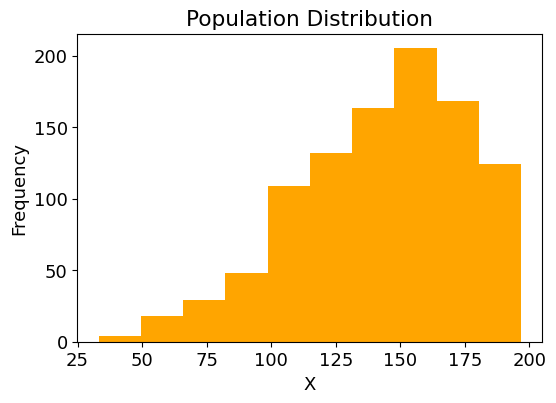

The population mean is: 142.7


In [20]:
a = 5
b = 2
pop_size = 1000
pop_dist = plot_pop(a,b,pop_size)


Based on 50000 samples of size 5 , here's what the sampling distribution of the sample mean looks like.



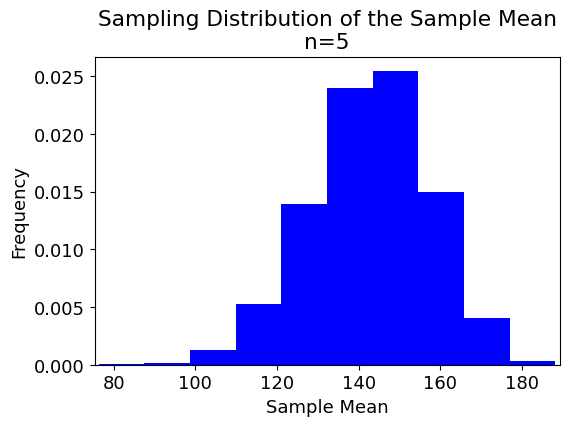

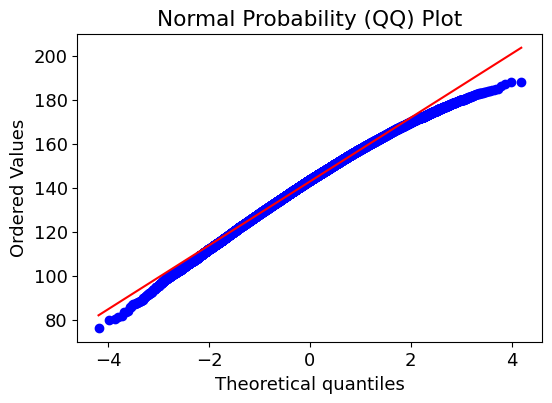


The mean of the sample means is: 142.8
The standard deviation of the sample means is: 14.5


In [22]:
sample_size = 5 # <--- try changing sample sizes
sample_repeats = 50000 # needs to be a large number (to approximate infinitely many samples)
samples = sample_procedure(pop_dist,sample_size,sample_repeats) # call the sampling procedure
plot_sampling_dist(samples,pop_dist,sample_size,sample_repeats) 

In [40]:
# this function creates the population distribution
# def create_pop(shape):
#     # a "beta" distribution is used to create the underlying distribution
#     # a beta distribution takes two (positive) parameters (a,b)
#     # and can take various shapes depending on these values
#     # https://en.wikipedia.org/wiki/Beta_distribution
#     if shape=="uniform":
#         a,b=1,1
#     elif shape=="skewed":
#         a,b=.1,1
#     elif shape=="normal":
#         a,b=10,10
#     elif shape=="bimodal":
#         a,b=0.05,0.05
#     else:
#         return [0]
#     population = stats.beta.rvs(a, b, size=10000)*200
#     return population

# this function plots the population distribution
# def plot_pop(pop):
#     print("Here's a population of size", len(pop))
#     print("The population mean is:", round(numpy.mean(pop), 1))
#     plt.hist(pop, color="orange")
#     plt.title("Population Distribution")
#     plt.xlabel("X")
#     plt.ylabel("Frequency")
#     plt.show()


# this function implements the full sampling process
def sample_procedure(pop_dist, n, repeats):
    # print("\nTaking samples of size", n, "...")
    sample_means = []

    for i in range(repeats):
        sample = numpy.random.choice(pop_dist, n)
        # by default, numpy.random.choice uses replace=True
        this_mean = numpy.mean(sample)
        sample_means.append(this_mean)
        # if i < 3:
        #     print("\nSample #", i + 1, ":", [round(elem, 2) for elem in sample])
        #     print("This sample mean is:  ", round(this_mean, 2))
    # print("\n...\n...\nSampling many more times...\n")
    # print(
    #     "Based on",
    #     repeats,
    #     "samples, the mean of the sampling distribution is",
    #     round(numpy.mean(sample_means), 2),
    # )
    # print("and the standard error is =", round(numpy.std(sample_means), 2))
    return sample_means


# this function plots the sampling distribution
def plot_sampling_dist(means, n):
    plt.hist(means, color="blue")
    plt.title("Sampling Distribution of the Sample Mean\n" + "Sample size=" + str(n))
    plt.xlabel("Sample Mean")
    plt.ylabel("Frequency")
    plt.show()


# this function creates an upper and lower bound for a confidence interval
def confidence_interval(point_estimate, SE, conf_level):
    z = stats.norm.ppf(
        1 - (1 - conf_level) / 2
    )  # gives 1.96 for a 95% confidence level
    lowbound = point_estimate - z * SE
    highbound = point_estimate + z * SE
    return lowbound, highbound


# this function calculates the percentage of
# confidence intervals that contain the population mean
def confidence_interval_accuracy(pop_mean, means, repeats, conf_level):
    count = 0
    standard_error = numpy.std(means)
    for i in range(repeats):
        this_mean = means[i]
        low, high = confidence_interval(this_mean, standard_error, conf_level)
        # if the population parameter is inside the interval, count it
        if pop_mean > low and pop_mean < high:
            count += 1
    return count / repeats * 100


# this function evaluates the accuracy of several different
# confidence intervals for each sample and plots the result
def confidence_interval_accuracy_chart(population_mean, sample_means, sample_repeats):
    print("Allow 5-10 seconds to test all of those confidence intervals...")
    ci = [0.5, 0.6, 0.7, 0.8, 0.9]
    ci_pct = [element * 100 for element in ci]
    ci_success = []
    for conf in ci:
        ci_success.append(
            confidence_interval_accuracy(
                population_mean, sample_means, sample_repeats, conf
            )
        )
    for i in range(len(ci)):
        print(
            "With a",
            round(ci_pct[i], 0),
            "% confidence level:",
            round(ci_success[i], 2),
            "% of intervals capture the population mean",
        )
    plt.scatter(ci_pct, ci_success)
    plt.title("Confidence Interval Accuracy")
    plt.xlabel("Confidence Interval (%)")
    plt.ylabel("Percent of CIs that Include the Pop Mean")
    plt.plot([50, 99], [50, 99], "r-")
    plt.show()


# this function runs the whole sampling and evaluation procedure
def do_that_confidence_interval_thang(population, sample_size, sample_repeats):
    # First, create and plot the population distribution (in orange)
    # population = create_pop(population_shape)

    # if len(population) == 1:
    #     print(
    #         "Hey! That's not one of the choices for the shape of the population distribution"
    #     )
    #     return
    # plot_pop(population)

    # Now, run the sampling procedure many times and plot our approximation
    # of the sampling distribution of the sample means
    sample_means = sample_procedure(population, sample_size, sample_repeats)
    # plot_sampling_dist(sample_means, sample_size)

    # Finally, construct a plot to show the accuracy of various confidence intervals
    confidence_interval_accuracy_chart(
        numpy.mean(population), sample_means, sample_repeats
    )


You can call these functions Herbie, because they're fully loaded!


Allow 5-10 seconds to test all of those confidence intervals...
With a 50.0 % confidence level: 48.17 % of intervals capture the population mean
With a 60.0 % confidence level: 59.2 % of intervals capture the population mean
With a 70.0 % confidence level: 69.67 % of intervals capture the population mean
With a 80.0 % confidence level: 79.69 % of intervals capture the population mean
With a 90.0 % confidence level: 90.04 % of intervals capture the population mean


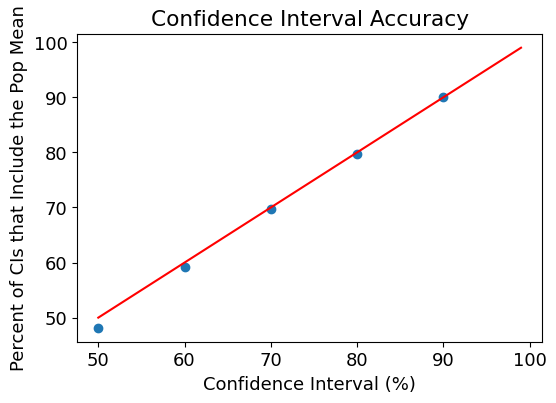

In [41]:
# RUN THIS CELL MULTIPLE TIMES

# SET VALUES
sample_size = 5  # try different sample sizes (e.g., n=5 and n=100)
# population_shape = "skewed"     # can be uniform, skewed, normal, or bimodal
sample_repeats = 10000  # this needs to be a large number

# CREATE THE POPULATION, SAMPLE FROM IT, AND EVALUATE THE CONFIDENCE INTERVALS
do_that_confidence_interval_thang(control["SkinThickness"], sample_size, sample_repeats)
